In [142]:
import sys

import matplotlib.pyplot as plt
import numpy
import torch
import torch.utils.data as data
import torch.nn as nn
import pytorch_lightning as pl

from torchdyn.core import NeuralODE
from torchdyn.models import CNF, hutch_trace
from torchdyn.datasets import *
from torchdyn import *

sys.path.append('../')
from datasets.dist import Gaussian, GMM

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Dataset(data.Dataset):
    def __init__(self, source, length, device):
        self.length = length
        self.source = source
        self.device = device

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        return self.sample(1).squeeze(0)

    def sample(self, N, t=0.0):
        x = self.source.sample(N)
        logp = self.source.get_density(x)[:,None]
        t0 = t * torch.ones(N,1, device=device)
        return torch.cat([logp, t0, x], dim=1)

class TinyFlow(nn.Module):
    def __init__(self, num_hidden_units):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(3, num_hidden_units),
            nn.SELU(),
            nn.Linear(num_hidden_units, num_hidden_units),
            nn.SELU(),
            nn.Linear(num_hidden_units, num_hidden_units),
            nn.SELU(),
            nn.Linear(num_hidden_units, 2)
        )
    def forward(self, x):
            dt = torch.ones_like(x[:,:1])
            dx = self.f(x)
            return torch.cat([dt, dx], dim=1)
    

# Time-dependent continuous normalizing flow
class CNFLearner(pl.LightningModule):
    def __init__(self, t_span:torch.Tensor, model:nn.Module, source, target):
        super().__init__()
        self.t_span = t_span
        self.model = NeuralODE(CNF(model), sensitivity='adjoint', solver='rk4', solver_adjoint='dopri5', atol_adjoint=1e-4, rtol_adjoint=1e-4).to(device)
        # Initialize source, target, train
        self.source = source
        self.target = target
        self.source_set = Dataset(source, 1000, device)
        self.target_set = Dataset(target, 1000, device)
        self.trainloader = data.DataLoader(self.source_set, batch_size=250, shuffle=True)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x0 = batch
        t_eval, trajectory = self.model(x0, t_span)
        x1 = trajectory[-1] # select last point of solution trajectory
        pushforward_logp = x1[:,0]
        pushforward_t = x1[:,1]
        pushforward_x = x1[:,2:]
        target_logp = self.target.get_density(pushforward_x)
        loss = torch.mean(pushforward_logp - target_logp)
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return self.trainloader

    # Utility functions
    def graph(self, trajectory):
        # Plot evolution
        N = len(self.t_span)
        fig, axs = plt.subplots(1, N, figsize=(8 * N,8))
        for i in range(N):
            axs[i].hist2d(trajectory[i,:,2], trajectory[i,:,3], bins=100, density=True)
        plt.show()      

    def graph_marginals(self, N):
        X_test = self.source_set.sample(N)
        t_span = self.t_span
        t_eval, trajectory = self.model(X_test.cpu(), t_span.cpu())
        trajectory = trajectory.detach().cpu().numpy()
        self.graph(trajectory)

    def graph_backwards_marginals(self, N):
        X_target = self.target_set.sample(N, t=1.0)
        t_span = torch.flip(self.t_span, dims=(0,))
        t_eval, trajectory = self.model(X_target.cpu(), t_span.cpu())
        trajectory = trajectory.detach().cpu().numpy()
        self.graph(trajectory)

class RegressionTarget
        

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
# Initialize source and target
source = GMM(nmode=2, device=device)
target = Gaussian(torch.zeros(2, device=device), torch.eye(2, device=device))

# Initialize flow
flow = TinyFlow(16)
num_timesteps = 30
t_span = torch.linspace(0,1,num_timesteps)
cnf = CNFLearner(t_span, flow, source, target)

# Train
trainer = pl.Trainer(min_epochs=20, max_epochs=30)
trainer.fit(cnf)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 642   
------------------------------------
642       Trainable params
0         Non-trainable params
642       Total params
0.003     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=30` reached.


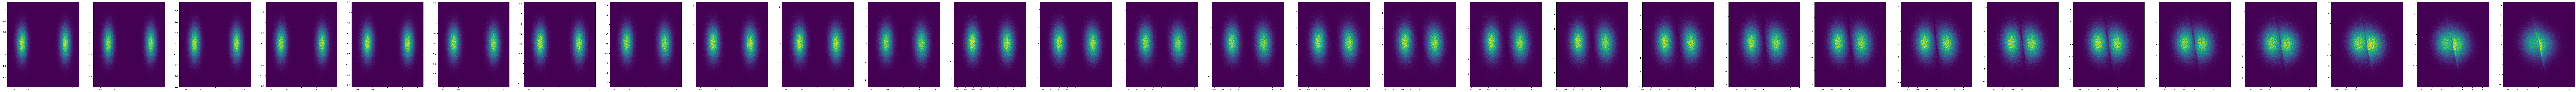

In [144]:
cnf.graph_marginals(100000)

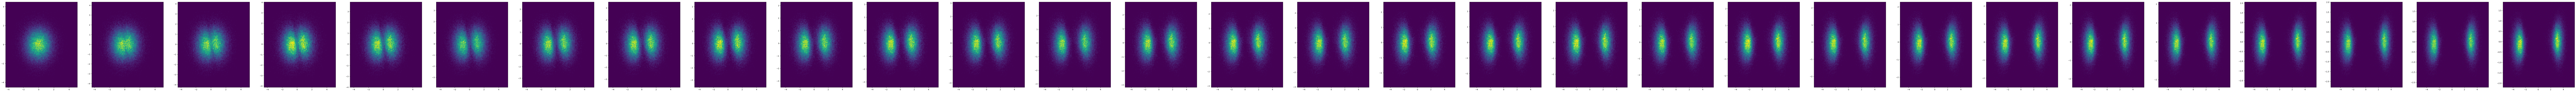

In [145]:
cnf.graph_backwards_marginals(100000)